# 2a2 Comparing Curvatures on Toy Manifolds

::: {#cell-1 .cell 0=‘h’ 1=‘i’ 2=‘d’ 3=‘e’}

``` python
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *

%load_ext autoreload
%autoreload 2
```

    The autoreload extension is already loaded. To reload it, use:
      %reload_ext autoreload

:::

In [ ]:
X, ks = ellipsoid(2000, seed=19323)
X

array([[ 2.00397824, -0.41691384,  0.71437483],
       [ 1.27475224, -0.11175413,  0.90350592],
       [-1.91620722,  0.99866728,  0.58539095],
       ...,
       [-2.97769204, -0.03548212,  0.12042399],
       [ 2.35053893, -0.31803095,  0.60068419],
       [-0.5358212 , -1.86937732, -0.30733797]])

> Which will emerge victorious?

The comparison consists of two parts: 1. A figure showing the visual
differences, both in 3d scatter plots, and correlation plots. 2. Tables
computing the resilience to noise across methods.

# Machinery

Load up the results:

In [ ]:
curvatures = {
    'Diffusion Curvature' : np.load("../results/toy_dataset_diffusion_curvature.npz"),
    # 'Unsigned Diffusion Curvature' : np.load("../results/toy_dataset_neurips_laziness_no_comparison.npz"),
    # 'AdaL-PCA' : np.load("../results/toy_dataset_toy_datasets_principal_curvature_heuristic.npz"),
    # 'AdaL-PCA' : np.load("../results/toy_dataset_toy_datasets_principal_curvature_heuristic_filtered.npz"), # outlier points filtered out
    # 'AdaL-PCA' : np.load("../results/toy_dataset_toy_datasets_principal_curvature_no_heuristic_08_15.npz"),
    'Hickok & Blumberg' : np.load("../results/toy_dataset_toy_datasets_hickock_curvature_r3.14.npz"),
    'Ollivier-Ricci' : np.load("../results/toy_dataset_toy_datasets_ollivier_curvature_a0.5.npz"),
    'Forman-Ricci' : np.load("../results/toy_dataset_toy_datasets_forman_curvature.npz"),
    'Ground Truth Curvature' : np.load("../results/toy_datasets_ground_truth_curvatures_2000.npz"),

}
scaled_curvatures = dict(curvatures)

And the data

In [ ]:
Xs = np.load("../results/toy_data_saved_2000.npz")
Ks = np.load("../results/toy_datasets_ground_truth_curvatures_2000.npz")

In [ ]:
Xs['Ellipsoid'].shape

(2000, 3)

In [ ]:
# # Establish Datasets
# n_points = 2000
# Xs = {}
# Ks = {}
# Xs['Torus'], Ks['Torus'] = torus(n_points, use_guide_points=False, seed=19323)
# Xs['Saddle'], Ks['Saddle'] = paraboloid(n_points, use_guide_points=False, seed=19323)
# Xs['sphere'], Ks['sphere'] = sphere(n_points,)
# Xs['Ellipsoid'], Ks['Ellipsoid'] = ellipsoid(n_points, seed=19323)
# Xs['hyperboloid'], Ks['hyperboloid'] = hyperboloid(n_points, seed=19323)
# # Noised Versions
# for noise_scale in [0.1, 0.2, 0.3, 0.4, 0.5]:
#     Xs[f'Torus noise = {noise_scale}'], Ks[f'Torus noise = {noise_scale}'] = torus(n_points, use_guide_points=False, seed=19323, noise = noise_scale)
#     # Xs['plane noise = {noise_scale}'] = np.hstack([plane(n_points, dim=2),np.zeros((n_points,1))])
#     # Ks['plane noise = {noise_scale}'] = np.zeros(len(Xs['plane']))
#     Xs[f'Saddle noise = {noise_scale}'], Ks[f'Saddle noise = {noise_scale}'] = paraboloid(n_points, use_guide_points=False, seed=19323, noise = noise_scale)
#     # Xs['sphere = {noise_scale}'], Ks['sphere = {noise_scale}'] = sphere(n_points,)
#     Xs[f'Ellipsoid noise = {noise_scale}'], Ks[f'Ellipsoid noise = {noise_scale}'] = ellipsoid(n_points, seed=19323, noise = noise_scale)
#     Xs[f'hyperboloid noise = {noise_scale}'], Ks[f'hyperboloid noise = {noise_scale}'] = hyperboloid(n_points, seed=19323, noise = noise_scale)

In [ ]:
curvatures['Diffusion Curvature']['Torus'].shape

(2000,)

# Results

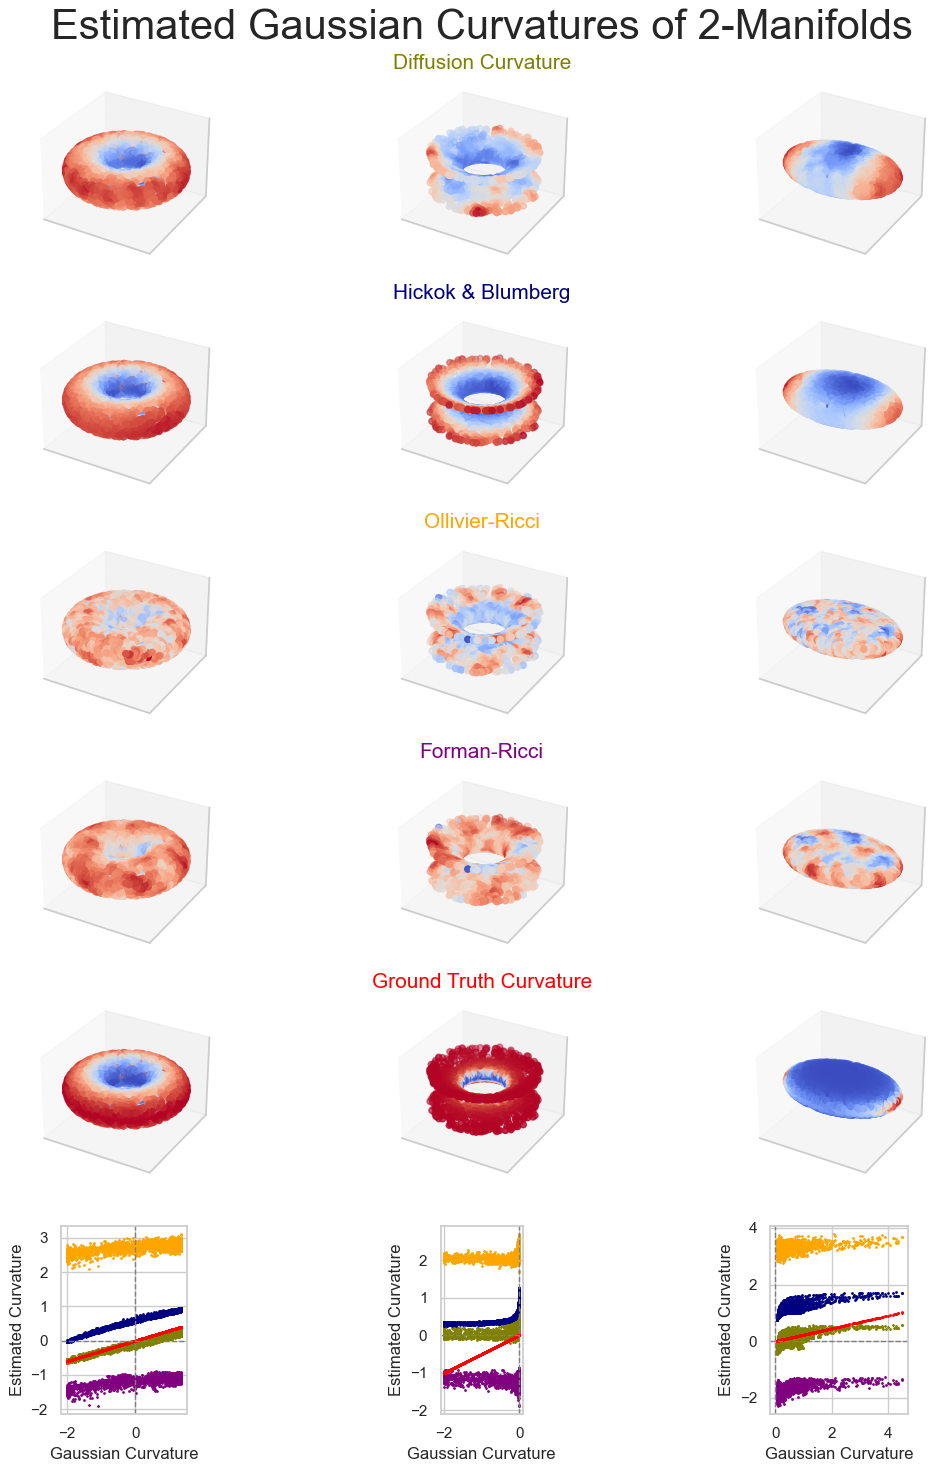

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
import numpy as np

# Assuming Xs, labels, ground_truth_labels, and key_names are defined
# For example:
key_names = ['Torus', 'Hyperboloid', 'Ellipsoid']
labels = curvatures
ground_truth_labels = Ks

# Set the style of seaborn
sns.set(style="whitegrid")

fig_shape = (len(curvatures.keys()) + 1, len(key_names))
method_colors = ['olive', 'navy', 'orange', 'purple','red']
assert len(method_colors) == len(curvatures.keys())

ordered_keys = curvatures.keys() #['Gaussian', 'Adal-PCA', 'Unsigned Diffusion Curvature', 'Hickok & Blumberg']
assert set(ordered_keys) == set(curvatures.keys())

# Create a figure and axes with 2 rows and 3 columns
fig, axs = plt.subplots(fig_shape[0], fig_shape[1], figsize=(fig_shape[0]*2, fig_shape[1]*5), subplot_kw={'projection': '3d'} if plt.matplotlib.__version__ < '3.4.0' else None)

for i, key in enumerate(key_names):
    # 3D scatter plot for the first row
    lim = np.max(np.linalg.norm(Xs[key], axis=1))
    # if plt.matplotlib.__version__ >= '3.4.0':

    # plot the curvature for each method
    for j, method_name in enumerate(ordered_keys):
        axs[j, i].remove()
        axs[j, i] = fig.add_subplot(fig_shape[0], fig_shape[1], i + j*fig_shape[1] + 1, projection='3d')
        axs[j, i].axes.set_xlim3d(left=-lim, right=lim)
        axs[j, i].axes.set_ylim3d(bottom=-lim, top=lim)
        axs[j, i].axes.set_zlim3d(bottom=-lim, top=lim)
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        axs[j, i].set_zticks([])

        scaled_labels = labels[method_name][key]
        scaled_labels = scaled_labels / (max(scaled_labels) - min(scaled_labels))
        scatter3d = axs[j, i].scatter(Xs[key][:, 0], Xs[key][:, 1], Xs[key][:, 2], c=scaled_labels, cmap = 'coolwarm')
        if i == 1:
            axs[j, i].set_title(f'{method_name}',fontsize=15, c = method_colors[j])

    # Scatter plot for the second row, colored by labels
    # axs[j+1, i].remove()
    # axs[j+1, i] = fig.add_subplot(fig_shape[0], fig_shape[1], i+4)
    for k, method_name in enumerate(ordered_keys):
        # min max scaling
        scaled_labels = labels[method_name][key]
        scaled_labels = scaled_labels / (max(scaled_labels) - min(scaled_labels))
        scatter2d = axs[j+1, i].scatter(ground_truth_labels[key], scaled_labels, c = method_colors[k], s = 1)
        axs[j+1,i].set_aspect('equal')
    # axs[1, i].set_title(f'')
    axs[j+1, i].set_xlabel('Gaussian Curvature')
    axs[j+1, i].set_ylabel('Estimated Curvature')
    
    
    # Highlight the origin lines in 2D scatter plots
    axs[j+1, i].axhline(0, color='gray', linewidth=1, linestyle='--')
    axs[j+1, i].axvline(0, color='gray', linewidth=1, linestyle='--')

    # # Add colorbar for each subplot
    # fig.colorbar(scatter3d, ax=axs[0, i], fraction=0.046, pad=0.04)
    # fig.colorbar(scatter2d, ax=axs[1, i], fraction=0.046, pad=0.04)
plt.suptitle("Estimated Gaussian Curvatures of 2-Manifolds", fontsize=30)
plt.tight_layout()
plt.show()


In [ ]:
Xs['Ellipsoid']

array([[ 0.63842898, -0.41691384, -0.95459822],
       [-1.08160955,  0.99866728,  0.78783205],
       [-2.40019712, -0.81698673, -0.43934956],
       ...,
       [-0.45061831, -1.42750305,  0.68410298],
       [-0.42009336,  1.9781941 , -0.04558851],
       [ 1.19841906, -1.48378612, -0.53853133]])

# Table

In [ ]:
import pandas as pd

In [ ]:
from sklearn.metrics import mean_squared_error
def root_mse_between(labels, method, dataset):
    truth = labels['Ground Truth Curvature'][dataset]
    computed = labels[method][dataset]
    return np.sqrt(mean_squared_error(truth, computed))

In [ ]:
from scipy.stats import energy_distance
def energy_between(labels, method, dataset):
    truth = labels['Ground Truth Curvature'][dataset]
    computed = labels[method][dataset]
    return energy_distance(truth, computed)

In [ ]:
from scipy.stats import pearsonr
def pearson_correlation_between(labels, method, dataset):
    truth = labels['Ground Truth Curvature'][dataset]
    computed = labels[method][dataset]
    rho, confidence = pearsonr(truth, computed)
    return rho

In [ ]:
def sign_accuracy_between(labels, method, dataset):
    truth = np.sign(labels['Ground Truth Curvature'][dataset])
    computed = np.sign(labels[method][dataset])
    accuracy = np.sum((truth == computed).astype(int))/len(truth)
    return accuracy

In [ ]:
noise_scales = [0.05, 0.1, 0.15, 0.2, 0.25]
dataset_names = ['Torus'] + [f'Torus noise = {x}' for x in noise_scales] + ['Hyperboloid'] + [f'Hyperboloid noise = {x}' for x in noise_scales] + ['Ellipsoid'] + [f'Ellipsoid noise = {x}' for x in noise_scales]

# metrics_collected = {
#         'RMSE':{}, 'ED':{}, 'PCC':{}
#     }
metrics_collected = {
    'Pearson Correlation':{}, 'Sign Accuracy':{},
    }


for method in labels.keys():
    if method == 'Ground Truth Curvature': 
        pass
    else:
        print(method)
        # metrics_collected['RMSE'][method] = {}
        # metrics_collected['ED'][method] = {}
        metrics_collected['Pearson Correlation'][method] = {}
        metrics_collected['Sign Accuracy'][method] = {}
        
        for dname in dataset_names:
            try:
                # metrics_collected['RMSE'][method][dname] = root_mse_between(curvatures, method, dname)
                # metrics_collected['ED'][method][dname] = energy_between(curvatures, method, dname)
                metrics_collected['Pearson Correlation'][method][dname] = pearson_correlation_between(curvatures, method, dname)
                metrics_collected['Sign Accuracy'][method][dname] = sign_accuracy_between(curvatures, method, dname)
            except KeyError:
                pass

Diffusion Curvature
Hickok & Blumberg
Ollivier-Ricci
Forman-Ricci

In [ ]:


# Define the LaTeX table structure
def create_latex_table(metrics):
    header = r"""\begin{tabular}{lc|cccccc|cccccc|cccccc}
\toprule
\multirow{2}{*}{\textbf{Model}} & \multirow{2}{*}{\textbf{Metric}} & \multicolumn{6}{c|}{\textbf{Torus}} & \multicolumn{6}{c|}{\textbf{Ellipsoid}} & \multicolumn{6}{c}{\textbf{Saddle}} \\
& & 0.0 & 0.05 & 0.10 & 0.15 & 0.20 & \multicolumn{1}{c|}{0.25} & 0.0 & 0.05 & 0.10 & 0.15 & 0.20 & \multicolumn{1}{c|}{0.25} & 0.0 & 0.05 & 0.10 & 0.15 & 0.20 & 0.25 \\
\midrule
"""
    footer = r"\bottomrule\n\end{tabular}"

    # Start building the table content
    table_content = header

    # Function to find the best values for bolding
    def find_best_values(data, surfaces, noises, metric):
        best_values = {}
        for surface in surfaces:
            for noise in noises:
                key = f"{surface} noise = {noise}" if noise > 0 else surface
                values = [model_data.get(key, float('-inf') if metric == 'PCC' else float('inf')) for model_data in data.values()]
                best_value = max(values) if metric == 'PCC' else min(values)
                best_values[(surface, noise)] = best_value
        return best_values

    # Iterate over each metric
    for metric, models in metrics.items():
        best_values = find_best_values(models, ["Torus", "Ellipsoid", "Saddle"], [0, 0.05, 0.1, 0.15, 0.2, 0.25], metric)
        # Iterate over each model
        for model, data in models.items():
            model_escaped = model.replace('&', r'\&')  # Escape '&' in model names
            table_content += f"{model_escaped} & {metric} "
            for surface in ["Torus", "Ellipsoid", "Saddle"]:
                for noise in [0, 0.05, 0.1, 0.15, 0.2, 0.25]:
                    key = f"{surface} noise = {noise}" if noise > 0 else surface
                    value = data.get(key, "")
                    if value:
                        # Check if the value is the best and should be bolded
                        if value == best_values[(surface, noise)]:
                            table_content += f"& \\textbf{{{value:.3f}}} "
                        else:
                            table_content += f"& {value:.3f} "
                    else:
                        table_content += "& - "
            table_content += r"\\"
            table_content += "\n"
        table_content += r"\midrule" + "\n"

    table_content += footer
    return table_content

# Generate the LaTeX table
latex_table = create_latex_table(metrics_collected)

# Print the LaTeX table
print(latex_table)


\begin{tabular}{lc|cccccc|cccccc|cccccc}
\toprule
\multirow{2}{*}{\textbf{Model}} & \multirow{2}{*}{\textbf{Metric}} & \multicolumn{6}{c|}{\textbf{Torus}} & \multicolumn{6}{c|}{\textbf{Ellipsoid}} & \multicolumn{6}{c}{\textbf{Saddle}} \\
& & 0.0 & 0.05 & 0.10 & 0.15 & 0.20 & \multicolumn{1}{c|}{0.25} & 0.0 & 0.05 & 0.10 & 0.15 & 0.20 & \multicolumn{1}{c|}{0.25} & 0.0 & 0.05 & 0.10 & 0.15 & 0.20 & 0.25 \\
\midrule
Diffusion Curvature & Pearson Correlation & 0.979 & 0.978 & 0.978 & 0.972 & 0.959 & 0.937 & 0.606 & 0.626 & 0.638 & 0.640 & 0.634 & 0.621 & - & - & - & - & - & - \\
Hickok \& Blumberg & Pearson Correlation & 0.987 & 0.978 & 0.950 & 0.910 & 0.861 & 0.811 & 0.734 & 0.745 & 0.704 & 0.623 & 0.544 & 0.479 & - & - & - & - & - & - \\
Ollivier-Ricci & Pearson Correlation & \textbf{0.614} & \textbf{0.625} & \textbf{0.664} & \textbf{0.685} & \textbf{0.699} & \textbf{0.704} & \textbf{0.359} & \textbf{0.369} & \textbf{0.380} & \textbf{0.394} & \textbf{0.410} & \textbf{0.407} & - & - & - &

In [ ]:
# # Display one part of the table, with all of the metrics for one method for one dataset
# \begin{tabular}{lc|cccccc|cccccc|cccccc}
# \toprule
# \multirow{2}{*}{\textbf{Model}} & \multirow{2}{*}{\textbf{Metric}} & \multicolumn{6}{c|}{\textbf{Torus}} & \multicolumn{6}{c|}{\textbf{Ellipsoid}} & \multicolumn{6}{c}{\textbf{Hyperboloid}} \\
# & & 0.0 & 0.1 & 0.2 & 0.3 & 0.4 & \multicolumn{1}{c|}{0.5} & 0.0 & 0.1 & 0.2 & 0.3 & 0.4 & \multicolumn{1}{c|}{0.5} & 0.0 & 0.1 & 0.2 & 0.3 & 0.4 & 0.5 \\
# \midrule
# & RMSE & \textbf{0.462} & \textbf{1.391} & \textbf{2.023} & \textbf{2.056} & \textbf{2.060} & \textbf{2.048} & 0.430 & \textbf{0.849} & \textbf{0.564} & \textbf{1.760} & \textbf{1.988} & \textbf{2.061} & \textbf{0.293} & \textbf{0.400} & \textbf{0.567} & \textbf{0.673} & \textbf{0.753} & \textbf{0.776} \\
# AdaL-PCA & ED & \textbf{0.462} & \textbf{0.725} & \textbf{1.026} & \textbf{1.071} & \textbf{1.076} & \textbf{1.059} & \textbf{0.251} & \textbf{0.277} & \textbf{0.832} & \textbf{1.296} & \textbf{1.565} & \textbf{1.643} & 0.321 & \textbf{0.405} & \textbf{0.538} & \textbf{0.674} & \textbf{0.757} & \textbf{0.787} \\
# & PCC & \textbf{0.996} & \textbf{0.865} & \textbf{0.633} & \textbf{0.550} & \textbf{0.440} & \textbf{0.408} & \textbf{0.988} & \textbf{0.325} & \textbf{0.124} & -0.153 & -0.131 & -0.018 & \textbf{0.747} & \textbf{0.603} & \textbf{0.481} & \textbf{0.428} & \textbf{0.386} & \textbf{0.363} \\
# \midrule
# \multirow{2}{*}{Hickok et al. \cite{hickok2023intrinsic}} & RMSE & 1.302 & 7.489 & 15.914 & 19.143 & 19.971 & 19.944 & \textbf{0.388} & 6.730 & 15.647 & 20.135 & 21.007 & 20.852 & 2.025 & 4.032 & 10.077 & 12.829 & 13.532 & 13.230 \\
# & ED & 0.646 & 3.076 & 4.772 & 5.171 & 5.168 & 5.041 & 0.361 & 3.407 & 5.075 & 5.576 & 5.541 & 5.391 & 1.154 & 1.981 & 3.588 & 4.065 & 4.069 & 3.908 \\
# \midrule
# Diffusion Curvature & PCC & 0.445 & 0.270 & 0.304 & 0.308 & 0.273 & 0.243 & 0.149 & 0.057 & 0.002 & \textbf{0.017} & \textbf{0.044} & \textbf{0.048} & 0.398 & 0.333 & 0.282 & 0.336 & 0.342 & 0.327\\
# \bottomrule
# \end{tabular}}

In [ ]:
metrics_collected

{'Pearson Correlation': {'Diffusion Curvature': {'Torus': 0.9786817374678426,
   'Torus noise = 0.05': 0.978265759032812,
   'Torus noise = 0.1': 0.9784843348747349,
   'Torus noise = 0.15': 0.971599930820229,
   'Torus noise = 0.2': 0.9590619601561946,
   'Torus noise = 0.25': 0.9366552969963727,
   'Hyperboloid': 0.4714631283053223,
   'Hyperboloid noise = 0.05': 0.5009040578978289,
   'Hyperboloid noise = 0.1': 0.4745439670567541,
   'Hyperboloid noise = 0.15': 0.42244131393334916,
   'Hyperboloid noise = 0.2': 0.3497722510243202,
   'Hyperboloid noise = 0.25': 0.2974799860735752,
   'Ellipsoid': 0.6063911503862703,
   'Ellipsoid noise = 0.05': 0.6259102152497372,
   'Ellipsoid noise = 0.1': 0.6376820164502178,
   'Ellipsoid noise = 0.15': 0.6399253976216913,
   'Ellipsoid noise = 0.2': 0.6343716247006543,
   'Ellipsoid noise = 0.25': 0.6209996122238669},
  'Hickok & Blumberg': {'Torus': 0.98748854658898,
   'Torus noise = 0.05': 0.9784506979253901,
   'Torus noise = 0.1': 0.9500356

In [ ]:
# Flatten the nested dictionary
data = []
for metric, models in metrics_collected.items():
    for model, results in models.items():
        row = {'Model': model, 'Metric': metric}
        row.update(results)
        data.append(row)

# Create a DataFrame
metric_df = pd.DataFrame(data)

In [ ]:
from great_tables import GT, style, loc, exibble
from great_tables.data import sp500
import pandas as pd

df = metric_df

# Group the data by metric for proper sorting and display
df = df.sort_values(by=['Metric', 'Model']).reset_index(drop=True)

# Create the table with row groups
table = (
    GT(df, rowname_col="Model", groupname_col="Metric")
    .tab_header(title="Curvature on 2-Manifolds with Noise", subtitle="Pearson correlations and sign accuracies")
    .tab_stubhead(label="Model & Metric")
    .cols_label(
        Model="Model",
        Metric="Metric",
        **{col: col for col in df.columns if col not in ["Model", "Metric"]}
    )
    .tab_spanner(label="Torus", columns=[col for col in df.columns if "Torus" in col])
    .tab_spanner(label="Ellipsoid", columns=[col for col in df.columns if "Ellipsoid" in col])
    .tab_spanner(label="Hyperboloid", columns=[col for col in df.columns if "Hyperboloid" in col])
    .fmt_number(columns=[col for col in df.columns if col not in ["Model", "Metric"]], decimals=3)
)

# Function to apply styles to the best values
def apply_best_value_styles(df, table):
    for metric in df['Metric'].unique():
        metric_df = df[df['Metric'] == metric]
        for col in df.columns[2:]:
            # if metric == 'Pearson Correlation':
            best_value = metric_df[col].max()
            # else:  # For RMSE and other metrics where lower is better
            #     best_value = metric_df[col].min()
                
            best_indices = metric_df[metric_df[col] == best_value].index.tolist()
            for index in best_indices:
                table = table.tab_style(
                    style=style.text(weight="bold"),
                    locations=loc.body(columns=[col], rows=[index])
                )
    return table

# Apply the styles
table = apply_best_value_styles(df, table)

# Display the table (assuming in Jupyter Notebook)
display(table)

In [ ]:
metric_df

# Conclusion

Hey!

In [ ]:
X, ks = ellipsoid(n_points, seed=19323)
X

array([[ 2.00397824, -0.41691384,  0.71437483],
       [ 1.27475224, -0.11175413,  0.90350592],
       [-1.91620722,  0.99866728,  0.58539095],
       ...,
       [-2.97769204, -0.03548212,  0.12042399],
       [ 2.35053893, -0.31803095,  0.60068419],
       [-0.5358212 , -1.86937732, -0.30733797]])